In [1]:
import sys
sys.path.insert(1, '/workspace/share')
from inference import Dev_model
import numpy as np
from collections import OrderedDict
import cv2
import json
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from utils.torch_utils import prune
from models.experimental import attempt_load
from utils.torch_utils import select_device
import torch
import math
import copy
import glob
import os

In [2]:
damage = 'origin_crack'
path = Path('/workspace/share')
img_path = path/'coco'/damage/'images'
model_path = '../runs/exp13_origin_crack_v2/weights/origin_crack_yolo_v2_clean.pt'
#model_path=['prune.pt']

In [3]:
model = Dev_model(model_path,imgsz=1433)

Using CUDA device0 _CudaDeviceProperties(name='NVIDIA RTX A5000', total_memory=24256MB)

Fusing layers... Model Summary: 503 layers, 2.85976e+08 parameters, 2.7862e+08 gradients


In [4]:
data = json.load(open(path/'coco'/damage/'annotations'/'test_v2.json'))
print(len(data['images']),len(data['annotations']))

884 1546


[[366.7792757982553, 614.2190317596036, 164.46848478255095, 36.42243565689694], [469.40048439306395, 641.4410836035652, 41.9095750672692, 62.67029503938227], [478.2293336292971, 691.603653003522, 52.23735798104633, 30.16569124802595], [311.35801222847067, 696.6469572653905, 224.29814329554495, 99.19708504592631], [322.83384997968795, 780.5341543583559, 235.26589790563145, 43.784638426983406], [494.0427155673543, 905.5621616210033, 31.246138335405362, 11.791173979440146], [340.1702230099802, 883.158931060067, 78.41012072847036, 25.351024055796415], [238.86534653758957, 498.1871391818138, 110.48494856136062, 132.92214823453241]]
OrderedDict([('/workspace/share/coco/origin_crack/images/https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000502_323860634_2184000502_IMG_5136.JPG', OrderedDict([('boxes', [[472, 631, 514, 700], [340, 711, 551, 823], [341, 881, 445, 907], [285, 515, 551, 634], [355, 697, 382, 751], [484, 691, 531, 721], [496, 905, 521, 918], [474, 647, 501, 699]]), (

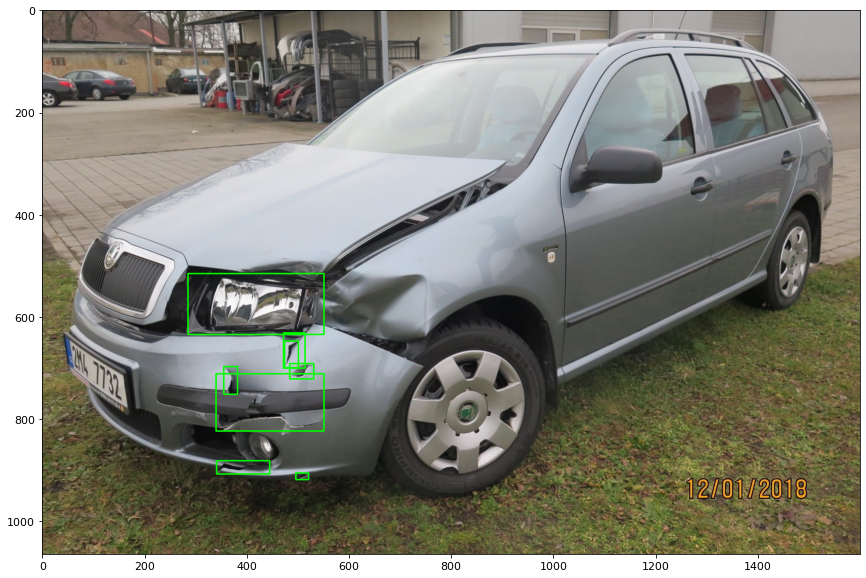

In [34]:
test_i = data['images'][409]
idx = test_i['id']
annos = [a['bbox'] for a in data['annotations'] if a['image_id']==idx]
print(annos)
i_path = img_path/test_i['file_name']
#print(data['images'][14])
out = model.inference(str(i_path),0.15)
print(out)
boxes = out[str(i_path)]['boxes']
print(boxes)
i = cv2.imread(str(i_path))
i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB )
for b in boxes:
    cv2.rectangle(i,(b[0],b[1]),(b[2],b[3]),(0,255,0),2)
plt.figure(figsize=(20,10))
plt.imshow(i)

In [8]:
def cal_iou(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[1]:box1[3],box1[0]:box1[2]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[1]:box2[3],box2[0]:box2[2]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())

def cal_new_iou_min(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[1]:box1[3],box1[0]:box1[2]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[1]:box2[3],box2[0]:box2[2]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / min(mask1.sum(),mask2.sum())
    #return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())

def cal_new_iou_max(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[1]:box1[3],box1[0]:box1[2]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[1]:box2[3],box2[0]:box2[2]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / max(mask1.sum(),mask2.sum())

def cal_v2(img,pred_boxes,pred_labels,gt_boxes,gt_labels):
    fp = 0
    tp = 0
    #fp_boxes = []
    
    for i in range(len(pred_boxes)):
        ious = [cal_iou(img,pred_boxes[i],gt_boxes[j]) for j in range(len(gt_boxes))]
        
        if len(ious) == 0:
            return 0,0,0
        
        idx = np.argmax(ious)

        if gt_labels[idx] == -1 :
            continue

        if ious[idx] >= 0.25:
            gt_labels[idx] = -1
            tp += 1
        else:
            if ious[idx] > 0 and cal_new_iou_min(img,pred_boxes[i],gt_boxes[idx]) > 0.8 and cal_new_iou_max(img,pred_boxes[i],gt_boxes[idx]) > 0.2:
                tp += 1
                gt_labels[idx] = -1
                #tp_check[i] = 1
            else:
                fp += 1
            #fp += 1
            #fp_boxes.append(pred_boxes[i])

    fn = len(gt_boxes) - tp
    
    return tp,fp,fn

# evaluate current model

In [ ]:
total_tp = 0
total_fn = 0
total_fp = 0

dummy_data = []

for i in tqdm(data['images']):
    i_path = img_path/i['file_name']
    gt_boxes = [a['bbox'] for a in data['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[int(b[0]),int(b[1]),int(b[0])+int(b[2]),int(b[1])+int(b[3])] for b in gt_boxes]
    gt_labels = [0 for i in gt_boxes]
    img = cv2.imread(str(i_path))
    #print('debug :',i_path)
    pred = model.inference(str(i_path))
    #print(i_path)
    pred = pred[str(i_path)]
    pred_boxes = pred['boxes']
    pred_labels = [0 for i in pred['labels']]
    
    tp,fp,fn = cal_v2(img,pred_boxes,pred_labels,gt_boxes,gt_labels)
    print(i['file_name'])
    print(tp,fp,fn)
    total_tp += tp
    total_fp += fp
    total_fn += fn
    
    if fn > 0 :
        dummy_data.append(i['file_name'])
    #break
print(total_tp,total_fp,total_fn)

In [11]:
def f1(tp,fp,fn):
    p = tp/(tp+fp)
    r = tp/(tp+fn)
    f1 = 2*p*r/(p+r)
    
    print('presicion : ',p)
    print('recall : ',r)
    print('f1 score : ',f1)

# save result into json file for ensemble inference later

In [ ]:
output = OrderedDict()
for i in tqdm(data['images']):
    img = cv2.imread(str(img_path/i['file_name']))
    i_path = img_path/i['file_name']
    h = i['height']
    w = i['width']
    
    pred = model.inference(str(i_path))
    pred = pred[str(i_path)]
    
    #print(pred)
    boxes = pred['boxes']
    
    for j in range(len(boxes)):
        boxes[j][0] = boxes[j][0]/w
        boxes[j][1] = boxes[j][1]/h
        boxes[j][2] = boxes[j][2]/w
        boxes[j][3] = boxes[j][3]/h
    #print(boxes)
    i_data = OrderedDict()
    i_data['name'] = i['file_name']
    i_data['boxes'] = boxes
    i_data['scores'] = pred['scores']
    i_data['labels'] = pred['labels']
    
    output[str(i['id'])] = i_data
    #plt.imshow(img)
    #print(output)
    #break
with open('yolo_'+damage+'_1408_thres_025.json', 'w', encoding='utf-8') as f:
    json.dump(output, f, ensure_ascii=False, indent=4)